# Поиск максимума функции $\phi\left(\tau,F_0,t_1\right)$

$$\phi\left(\tau,F_0,t_1\right)=\tau F_0\exp\left(-\frac{0.05}{\tau F_0}\right)\left[1-\exp\left(\frac{t_1 F_0-0.45}{\tau F_0}\right)-\exp\left(-\frac{0.5}{\tau F_0}\right)+\exp\left(\frac{t_1 F_0-0.95}{\tau F_0}\right)\right]$$

То есть, при фиксированных $t_1$ и $\tau$ алгоритм находит значение $F_0$, при котором достигается максимум $\phi\left(\tau,F_0,t_1\right)$.
Затем, вычисляется значение $\phi\left(\tau,F_0,t_1\right)$ при найденном $F_0$.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class PhiModel(tf.Module):
    def __init__(self,
                 time_constant = 0.01,
                 freq_pwr = 1.0,
                 filling_pulse = 20 * 10 ** (-6),
                 **kwargs
                ):
        super().__init__(**kwargs)
        
        self.time_constant = tf.Variable(time_constant, trainable=False)
        self.filling_pulse = tf.Variable(filling_pulse, trainable=False)
        self.frequency_pwr = tf.Variable(freq_pwr, trainable=True)
        
    def __call__(self, pwr=None):
        if pwr is None:
            frequency = tf.pow(10.0, self.frequency_pwr)
        else:
            frequency = tf.pow(10.0, pwr)
        
        a = self.time_constant * frequency
        b = self.filling_pulse * frequency
        
        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        phi = a * exp0 * (1.0 - exp1 - exp2 + exp3)
        
        return phi

In [3]:
np.log10(1)

0.0

In [4]:
tau = 0.01
model = PhiModel(time_constant = tau,
                 freq_pwr=float(np.log10(1/tau)),
                 filling_pulse=20 * 10 ** (-6)
                )

print('Variables: ', model.variables, '\n')
print('Inintial Phi:', model().numpy())

Variables:  (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2e-05>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>) 

Inintial Phi: 0.13515061


In [5]:
def optimize(model, n_iters=1000, learning_rate=0.1):
    freq_pwrs = list()
    phis = list()
    
    freq_pwrs.append(model.frequency_pwr.numpy())
    phis.append(model().numpy())
    
    for _ in range(n_iters):
        
        with tf.GradientTape() as t:
            current_loss = 0.0 - model()
            
        d_freq_pwr = t.gradient(current_loss, model.frequency_pwr)
        model.frequency_pwr.assign_sub(learning_rate * d_freq_pwr)
        
        freq_pwrs.append(model.frequency_pwr.numpy())
        phis.append(model().numpy())
        
    return freq_pwrs, phis

In [6]:
freq_pwrs, phis = optimize(model, n_iters=200, learning_rate=0.1)

In [7]:
def plot_optimizer(model):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    freq_scan = pd.DataFrame({'frequency_pwr': np.linspace(0.0, np.log10(2500), num=1000)})
    freq_scan['frequency'] = np.power(10.0, freq_scan.frequency_pwr)
    freq_scan['phi'] = freq_scan.frequency_pwr.apply(lambda x: model(x).numpy())

    optimizer = pd.DataFrame({'frequency_pwr': freq_pwrs, 'optimizer': phis})
    optimizer['frequency'] = np.power(10.0, optimizer.frequency_pwr)

    freq_scan.plot(x='frequency', 
                   y='phi', 
                   ax=ax, 
                   logx=True, 
                   grid=True, 
                   ylabel='$\phi$', 
                   xlabel='$F_0$, Hz', 
                   title=f'$\\tau$ = {model.time_constant.numpy():2.5f} s')
    
    optimizer.plot(x='frequency', y='optimizer', ax=ax, style='.r', logx=True, grid=True, ylabel='$\phi$', xlabel='$F_0$, Hz')

    plt.plot(optimizer.frequency.iloc[0], optimizer.optimizer.iloc[0], 'og', label='start_point')
    plt.plot(optimizer.frequency.iloc[-1], optimizer.optimizer.iloc[-1], 'ob', label='end_point')

    plt.legend()
    
    plt.xlim((1, 2500))
    plt.ylim((0, 0.18))

    plt.show()
    
    print(f'Frequency = {optimizer.frequency.iloc[-1]} Hz, phi = {optimizer.optimizer.iloc[-1]}, 1\phi = {1 / optimizer.optimizer.iloc[-1]}')

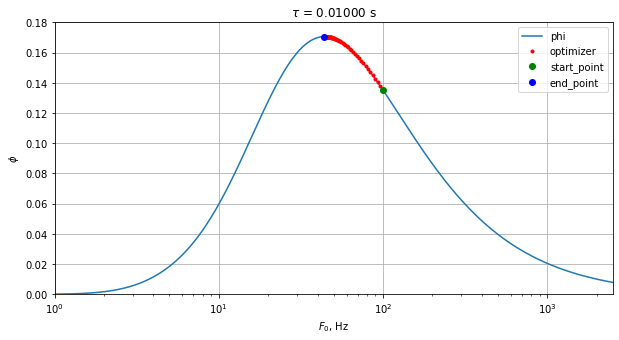

Frequency = 44.01829801993892 Hz, phi = 0.17058274149894714, 1\phi = 5.86225775956457


In [8]:
plot_optimizer(model)

In [9]:
1/model().numpy()

5.86225775956457

In [10]:
def report_n_iter(freq_pwrs, phis, start=0, number=30):
    end = start + number
    for i, (pwr, phi) in enumerate(zip(freq_pwrs[start: end], phis[start: end])):
        print(f'Iteration #{i+start:3d}: freq_pwr = {pwr:1.5f}, freq = {10**pwr:3.5f}, phi = {phi}')

In [11]:
report_n_iter(freq_pwrs, phis, number=len(freq_pwrs))

Iteration #  0: freq_pwr = 2.00000, freq = 100.00000, phi = 0.13515061140060425
Iteration #  1: freq_pwr = 1.98391, freq = 96.36350, phi = 0.13772018253803253
Iteration #  2: freq_pwr = 1.96806, freq = 92.90981, phi = 0.14021159708499908
Iteration #  3: freq_pwr = 1.95248, freq = 89.63637, phi = 0.14261451363563538
Iteration #  4: freq_pwr = 1.93722, freq = 86.54000, phi = 0.1449197232723236
Iteration #  5: freq_pwr = 1.92229, freq = 83.61685, phi = 0.14711908996105194
Iteration #  6: freq_pwr = 1.90775, freq = 80.86248, phi = 0.14920614659786224
Iteration #  7: freq_pwr = 1.89361, freq = 78.27193, phi = 0.15117569267749786
Iteration #  8: freq_pwr = 1.87990, freq = 75.83979, phi = 0.15302427113056183
Iteration #  9: freq_pwr = 1.86664, freq = 73.56019, phi = 0.1547500491142273
Iteration # 10: freq_pwr = 1.85386, freq = 71.42696, phi = 0.15635256469249725
Iteration # 11: freq_pwr = 1.84157, freq = 69.43367, phi = 0.15783309936523438
Iteration # 12: freq_pwr = 1.82978, freq = 67.57372, 

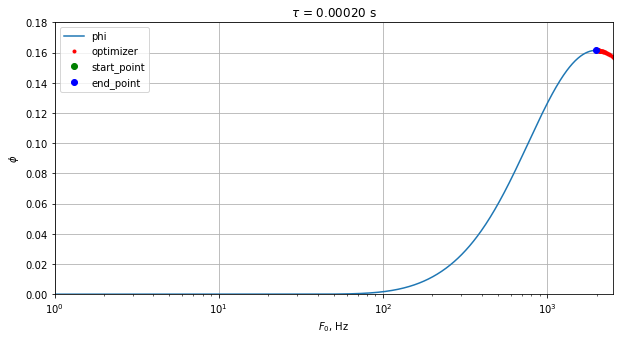

Frequency = 1986.8620084554514 Hz, phi = 0.16149884462356567, 1\phi = 6.191994762135168


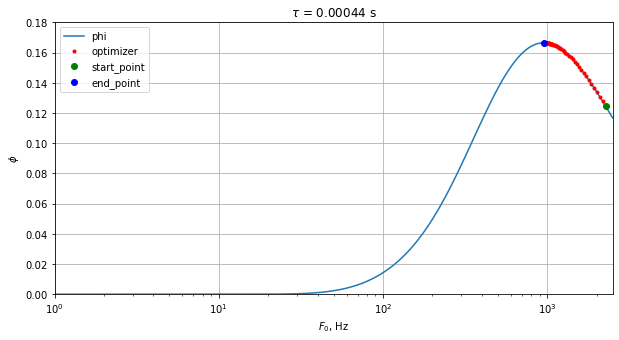

Frequency = 951.3146282262439 Hz, phi = 0.16648845374584198, 1\phi = 6.006422532619472


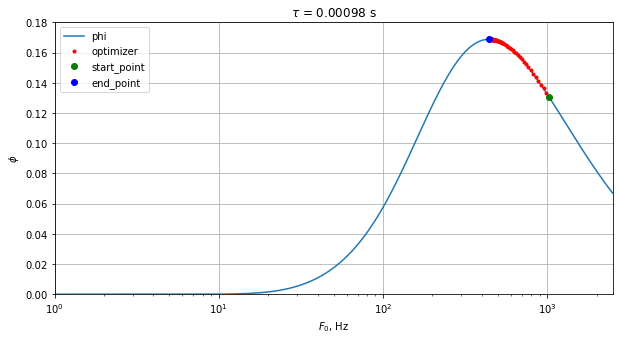

Frequency = 442.2438792575178 Hz, phi = 0.16881603002548218, 1\phi = 5.923608083006416


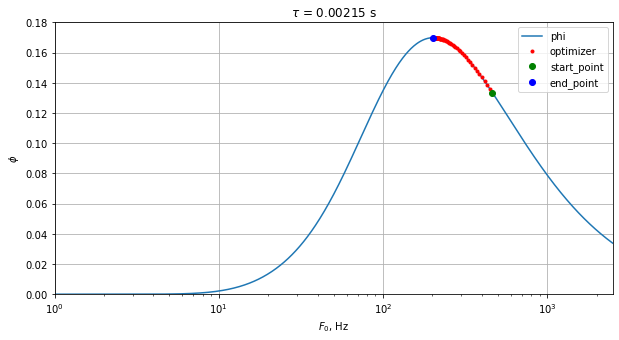

Frequency = 202.69333393552458 Hz, phi = 0.16988438367843628, 1\phi = 5.886356228556232


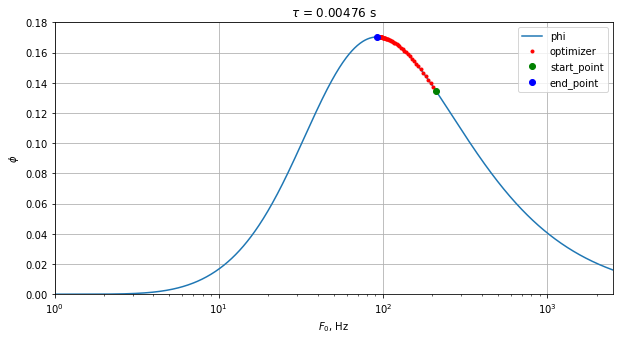

Frequency = 92.28873376779387 Hz, phi = 0.17037105560302734, 1\phi = 5.869541609990652


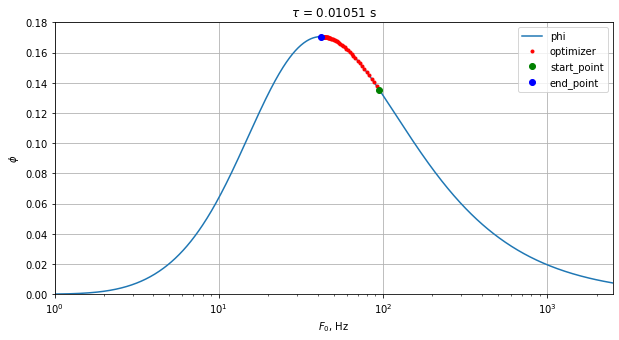

Frequency = 41.89322028951249 Hz, phi = 0.1705920398235321, 1\phi = 5.86193823014511


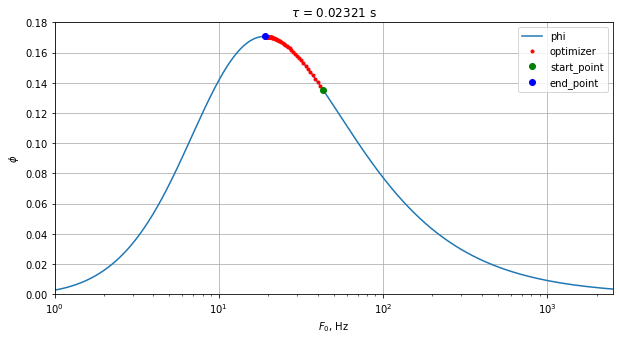

Frequency = 18.99064768474775 Hz, phi = 0.17069225013256073, 1\phi = 5.858496793049441


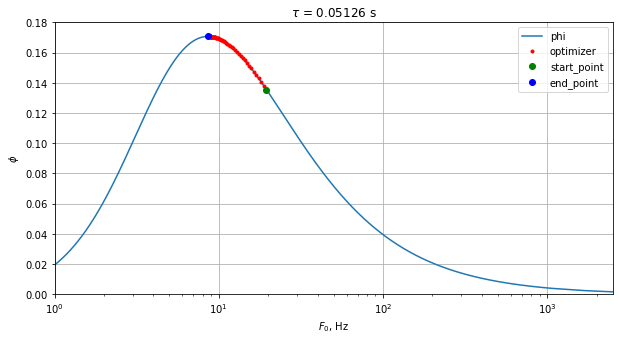

Frequency = 8.603275535418446 Hz, phi = 0.1707376390695572, 1\phi = 5.856939368785624


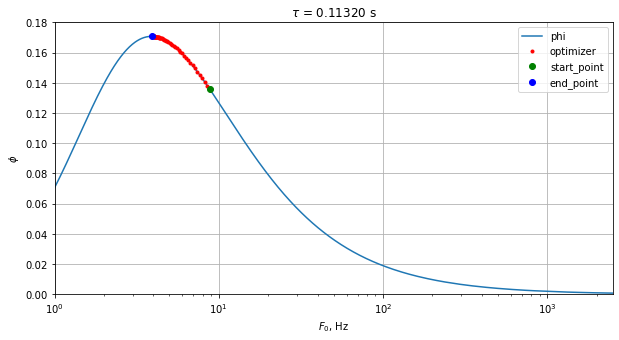

Frequency = 3.8964103184621 Hz, phi = 0.1707581877708435, 1\phi = 5.856234556330582


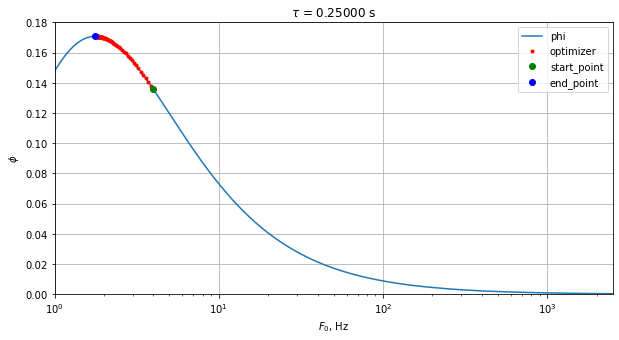

Frequency = 1.7644512872099711 Hz, phi = 0.17076750099658966, 1\phi = 5.855915172173016


In [12]:
start = np.log10(0.0002)
end = np.log10(0.25)
tau_pwrs = np.linspace(start, end, num=10)
taus = np.power(10, tau_pwrs)

for tau in taus:
    model = PhiModel(time_constant = float(tau),
                     freq_pwr=float(np.log10(1/tau)),
                     filling_pulse=20 * 10 ** (-6))
    
    freq_pwrs, phis = optimize(model, n_iters=200, learning_rate=0.1)
    
    plot_optimizer(model)